## Part I : Work with SMIL
In this part, the images are processed with functions in the library SMIL. 

In [1]:
import numpy as np;
import cv2
from tp_init import *

First, we transform the color space in L*a*b and extract its three channels

Original image


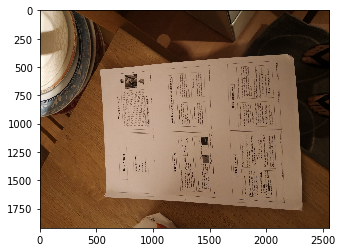

L*a*b image


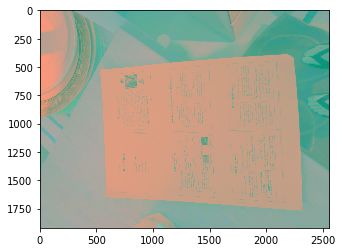

Before filtering: L channel, a channel, b channel


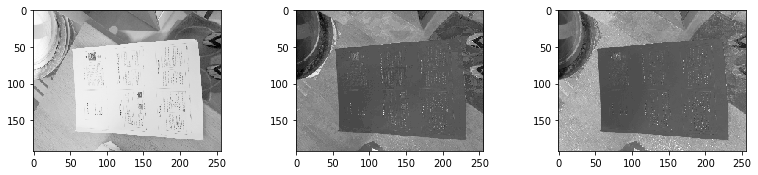

In [2]:

# Initialization
nl = HexSE()
colorim = Image("images/doc11.jpg")

# Convert to LAB space
colorim2 = Image(colorim)
RGBToLAB(colorim, colorim2)
imL, imA, imB = extractChannels(colorim2)

# Resize the images
scale(imL, 0.1, 0.1, imL)
scale(imA, 0.1, 0.1, imA)
scale(imB, 0.1, 0.1, imB)

print("Original image")
disp(colorim)
print("L*a*b image")
disp(colorim2)
print("Before filtering: L channel, a channel, b channel")
disp([imL,imA,imB])


After filtering: L channel, a channel, b channel


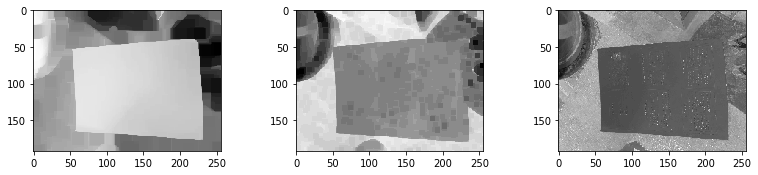

L gradient, a gradient, b gradient


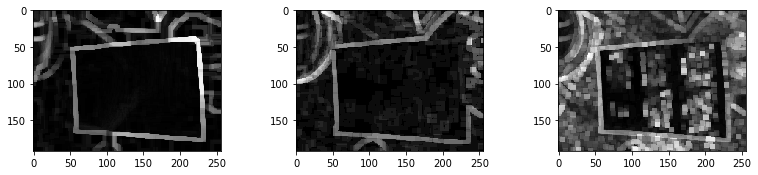

Filtered gradient image


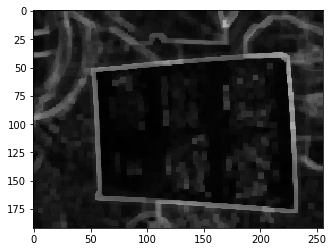

In [18]:
# Closing transformation on channel L to remove the words on the image
# Erosion transformation on channel a to remove the noise
imOutL, imOutA, imOutB = Image(imL), Image(imA), Image(imB)
close(imL, imOutL, SquSE(7))
erode(imA, imOutA, SquSE(3))
imOutB = imB

# Apply gradient transformation on L, a and b channels, then sum them up together
imgraL, imgraA, imgraB, imgra = Image(imL),Image(imA),Image(imB), Image(imL)
gradient(imOutL, imgraL, SquSE(3))
gradient(imOutA, imgraA, SquSE(3))
gradient(imB, imgraB, SquSE(3))
copy(imgraL, imgra)
close(imgra, imgra, SquSE(3))
add(imgraL, imgraA, imgra)
add(imgra, imgraB, imgra)

imlev, imbasins = Image(imgra), Image(imgra)
imtmp = Image(imgra)

# Erosion on gradient to remove the minimas of small area
erode(imgra, imtmp)

# Apply hBuild to remove the minimas of small difference
hBuild(imgra, 3, imgra)

print("After filtering: L channel, a channel, b channel")
disp([imOutL, imOutA, imOutB])
print("L gradient, a gradient, b gradient")
disp([imgraL, imgraA, imgraB])
print("Filtered gradient image")
disp(imgra)

Set markers and apply watershed algorithm

Marker image for watershed


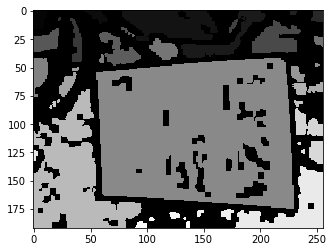

Basins image


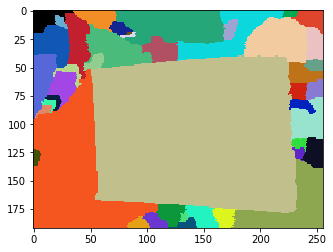

In [19]:


# Set a threshold equal to the mean value of imgra, then filter imgra to define markers for watershed algorithm
# The threshold here is the average value of imgra
immarker = Image(imgra)
thres = int(meanVal(imgra)[0])
compare(imgra, ">", thres, 0, 255, immarker)
label(immarker, immarker)

# Apply basins() to get seperate basins
basins(imgra, immarker, imbasins)


print("Marker image for watershed")
disp(immarker)
print("Basins image")
disp([imbasins], [True])

Since the result seems not satisfactory, we try to combine some segments using the MST algorithm. But to use the watershedEV, we have to predefine the number of regions we want to obtain, which depends on the image. 

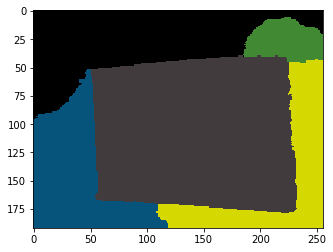

In [20]:

imFineSeg,MST = watershedEV(imgra,"d")
imSeg = Image(imFineSeg)

# Here we set the number of regions to 5
getEVLevel(imFineSeg, MST, 5, imSeg)
disp(imSeg, True)

The segmentation result is not bad. But to automatically scan the document, the machine doesn't know how many regions it shoulds obtain. So we should try another method.

We notice that if we can select a good threshold for imgra, we can effectively recognize the edges we want and remove the noise. Two algorithms are proposed here to select a good threshold: Triangle threshold and Otsu threshold. Since I can't find these two algorithms in SMIL, I decide to use OpenCV to process the image. Besides, OpenCV integrates several methods of Houghline detecting which are necessary to detect the edges of a piece of paper.

## Part II : Work with OpenCV
In this part, the images are processed with functions in the library OpenCV

In [21]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

Transform the color space in Lab and extract its three channels. Then apply closing transformation on l_channel and erosion transformation on a_channel.

Original image


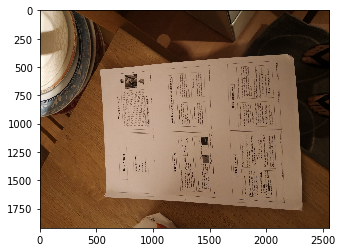

L channel


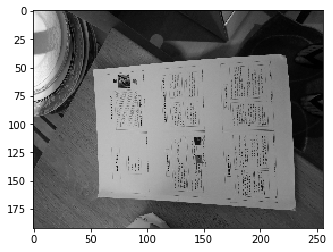

a channel


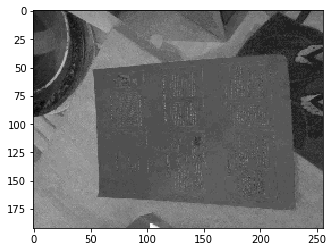

b channel


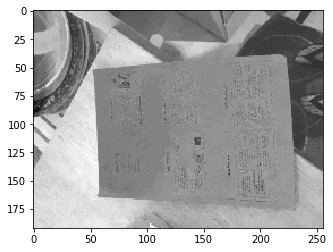

L channel after closing


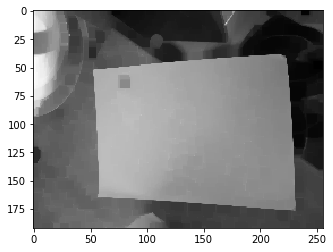

a channel after erosion


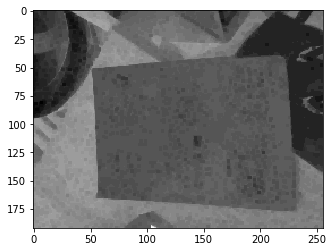

In [27]:
img = cv2.imread("images/doc11.jpg")
print("Original image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Resize the image
img = cv2.resize(img,None,fx=0.1, fy=0.1, interpolation = cv2.INTER_CUBIC)
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)

# Apply closing transformation on L channel
kernel = np.ones((7,7), np.uint8)
img_l = cv2.morphologyEx(l_channel, cv2.MORPH_CLOSE, kernel)

# Apply erosion transformation on A channel
kernel = np.ones((3,3), np.uint8)
img_a = cv2.erode(a_channel,kernel,iterations = 1)

img_b = b_channel


print("L channel")
plt.imshow(l_channel, "gray")
plt.show()
print("a channel")
plt.imshow(a_channel, "gray")
plt.show()
print("b channel")
plt.imshow(b_channel, "gray")
plt.show()
print("L channel after closing")
plt.imshow(img_l,"gray")
plt.show()
print("a channel after erosion")
plt.imshow(img_a,"gray")
plt.show()

Apply gradient on three channels, and sum them up.

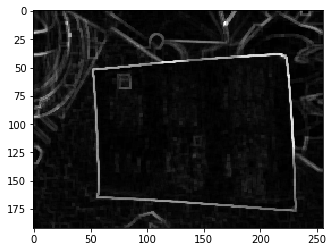

In [28]:
kernel = np.ones((3,3), np.uint8)
imgra_l = cv2.morphologyEx(img_l, cv2.MORPH_GRADIENT, kernel)
imgra_a = cv2.morphologyEx(img_a, cv2.MORPH_GRADIENT, kernel)
imgra_b = cv2.morphologyEx(img_b, cv2.MORPH_GRADIENT, kernel)
imgra = imgra_l + imgra_a + imgra_b

plt.imshow(imgra,"gray")
plt.show()

Apply Triangle threshold algorithm to select an appropriate threshold, then filter the gradient image.

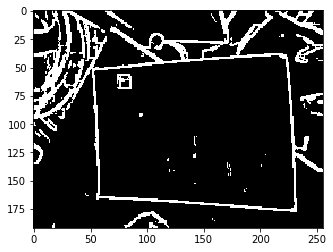

In [29]:
ret, thresh = cv2.threshold(imgra,0,255,cv2.THRESH_TRIANGLE)
plt.imshow(thresh,"gray")
plt.show()

The black areas of the image above are classified into several connected area. Then we define markers from these connected areas, and apply the watershed algorithm.

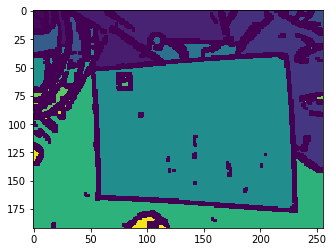

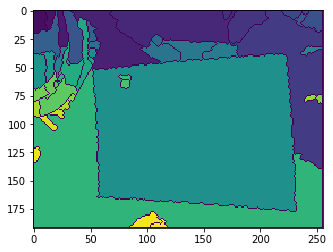

In [30]:

marker = cv2.bitwise_not(thresh)
kernel = np.ones((3,3), np.uint8)
marker = cv2.erode(marker, kernel)
ret, marker = cv2.connectedComponents(marker)
plt.imshow(marker)
plt.show()

imgra = cv2.merge((imgra_l,imgra_a,imgra_b))
imws = cv2.watershed(imgra,marker)

plt.imshow(imws)
plt.show()


The segmentation result is satisfactory, because most noise is removed by the threshold filtering. 

Then we are going to apply the Houghline algorithm to detect the edges of a document.

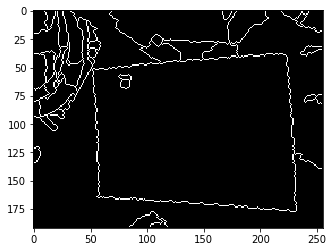

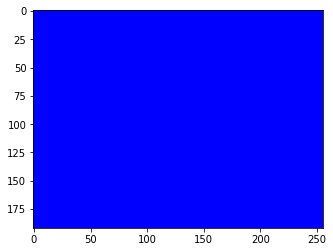

In [31]:
# Before using the houghlines algorithm, we have to process the images' formats. 
# NB : in the watershed image, the boundaries between the basins are set to -1.

# Convert the watershed image into uint8 type. 
imws8 = np.uint8(imws)

# Set the boundaries to 255 and the other regions to 0. 
lenx, leny = imws.shape
imws8[imws>=0] = 0
imws8[imws==-1] = 255

# Since the global edge of the watershed image is set as boundaries, we have to delete its four boundaries.
for i in range(lenx):
    imws8[i][0] = 0
    imws8[i][leny-1] = 0
for j in range(leny):
    imws8[0][j] = 0
    imws8[lenx-1][j] = 0

plt.imshow(imws8, "gray")
plt.show()

# Apply the classical houghlines algorithm
imgcopy = img.copy()
minLineLength = 30
maxLineGap = 10
lines = cv2.HoughLines(imws8,1,np.pi/180,10)

for x in range(0,len(lines)):
    for rho,theta in lines[x]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(imgcopy,(x1,y1),(x2,y2),(0,0,255),2)
        
plt.imshow(imgcopy, "gray")
plt.show()
        

There are too many houghline candidates, we have to select the best lines for the document edges.

We are going to define an energy for each line by "U = mean_distance / sqrt(lenth + 1)" according to the thesis "REAL-TIME DOCUMENT DETECTION IN SMARTPHONE VIDEOS".

In [32]:
def myCandidates(imIn, lines):
    
    imTmp = imIn.copy() 
    imTmp = 255 - imTmp # inverse the imTmp
    dist = cv2.distanceTransform(imTmp, cv2.DIST_L2, 3)
    
    imLine = imIn.copy()
    candidates = []
    for x in range(len(lines)):
        for rho,theta in lines[x]:
            imLine[:][:] = 0
            distTmp = dist.copy()
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(imLine,(x1,y1),(x2,y2),255,1)
            
            imLine[dist>3]=0
            distTmp[imLine==0]=0
            
            length = (imLine!=0).sum()
            meanDist = distTmp.sum()/(imLine!=0).sum()
            energy = meanDist / math.sqrt(length + 1)
            candidates.append([rho, theta, energy])
    return candidates

def draw(imIn, candidateLines, color=(255,0,0)):
    for rho, theta, _ in candidateLines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(imIn,(x1,y1),(x2,y2),color,1)

Calculate the enery of each line and classify the lines in two types: horizontal and vertical

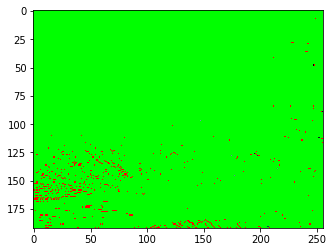

In [33]:


# Calculate the energy of each candidate line and obtain a list [rho, theta, energy]
candidateLines = myCandidates(imws8, lines)

# Divide the lines into vertical lines and horizontal lines
verticalLines = []
horizontalLines = []
for x in candidateLines:
    if (x[1]>=np.pi/4 and x[1]<3*np.pi/4):
        horizontalLines.append(x)
    else:
        verticalLines.append(x)

# Draw the lines
imgcopy = img.copy()
for rho, theta, _ in verticalLines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(imgcopy,(x1,y1),(x2,y2),(255,0,0),1)
    
for rho, theta, _ in horizontalLines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(imgcopy,(x1,y1),(x2,y2),(0,255,0),1)
        
        
plt.imshow(imgcopy)
plt.show()



Sort the candidate lines and draw the lines with low energy

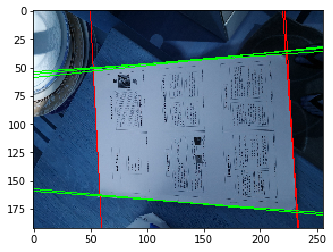

In [34]:
# Sort the candidate lines by their energies in ascending order
def takeThird(elem):
    return elem[2]

verticalLines.sort(key=takeThird)
horizontalLines.sort(key=takeThird)

# Draw the first 6 candidate lines
imgcopy = img.copy()
draw(imgcopy, verticalLines[0:3], (255,0,0))
draw(imgcopy, horizontalLines[0:5], (0,255,0))
        
plt.imshow(imgcopy)
plt.show()



Until now we cannot effectively detect the 4 boundaries. To improve the detection method, we might apply some cluster methods (e.g. k-means)to classify the couples (rho, theta) in several groups, each group contains a series of adjacent lines. Then we apply the enery sort to select the best candidate line of each group. 

To continue the detection, we also have to classify the selected candidates in top, bottom, left and right boundaries, then do the final decision for 4 boundaries.